In [1]:
import sys
sys.path.append('../src') 
from preprocessing import ImagePreprocessor
from detector import FaceDetector
from embedding import FaceNetEmbedding
from PIL import Image
import matplotlib.pyplot as plt
from db import FaceVectorDB

/home/david/miniconda3/envs/face_recog/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:matplotlib.font_manager:generated new fontManager


### Initialize

In [3]:
db = FaceVectorDB(
    "/home/david/face_duplicate_detection/face_db"
)
print(f"✓ Database initialized")
print(f"  Current count: {db.get_count()}")

✓ Database initialized
  Current count: 2080


### Add embeddings

In [6]:
test_images = [
    "/home/david/face_duplicate_detection/data/images/Al Pacino_1798.jpg",
    "/home/david/face_duplicate_detection/data/images/Al Pacino_1800.jpg",
    "/home/david/face_duplicate_detection/data/images/Al Pacino_1805.jpg",
]

In [7]:
import time
from pathlib import Path
def process_single_image(image_path, person_id = None):
        """
        Process single image through entire pipeline
        
        Args:
            image_path: Path to image file
            person_id: Optional person identifier
            
        Returns:
            Tuple: (success: bool, embedding: np.ndarray, metadata: dict)
        """
        start_time = time.time()
        
        # 1. Preprocess image
        preprocessor = ImagePreprocessor()
        img = preprocessor.preprocess(image_path)
        if img is None:
            return False, None, {"error": "Preprocessing failed"}
        
        # 2. Detect and align face
        detector = FaceDetector(detector_type="mtcnn")
        face_tensor = detector.detect_and_align(img)
        if face_tensor is None:
            return False, None, {"error": "No face detected"}
        
        # 3. Extract embedding
        embedding_extractor = FaceNetEmbedding()
        embedding = embedding_extractor.extract(face_tensor)
        if embedding is None:
            return False, None, {"error": "Embedding extraction failed"}
        
        processing_time = time.time() - start_time
        if not person_id:
             person_id = Path(image_path).stem.split('.')[0].replace(" ", "_")

        metadata = {
            "processing_time": processing_time,
            "detector": "mtncc"
        }
        
        return True, embedding, metadata, person_id

In [7]:
for image in test_images:
    success, embedding, metadata, person_id = process_single_image(image)

    if success:
        doc_id = db.add_embedding(
            embedding=embedding,
            image_path=image,
            person_id=person_id,
            metadata=metadata
        )
        print(f"✓ Added: {image}")
    else:
        print(f"✗ No face: {image}")

print(f"\nTotal embeddings: {db.get_count()}")

INFO:detector:Initializing MTCNN detector
INFO:detector:Initializing MTCNN detector


✓ Added: /home/david/face_duplicate_detection/data/images/Al Pacino_1798.jpg


INFO:detector:Initializing MTCNN detector


✓ Added: /home/david/face_duplicate_detection/data/images/Al Pacino_1800.jpg
✓ Added: /home/david/face_duplicate_detection/data/images/Al Pacino_1805.jpg

Total embeddings: 3


### Search similiar faces 

In [8]:
query_path = test_images[0]
query_img = Image.open(query_path)
success, query_embedding, metadata, person_id = process_single_image(query_path)

INFO:detector:Initializing MTCNN detector


In [9]:
n_results = 6
results = db.search(query_embedding)

Match 1:
  Image: data/images/Al Pacino_1798.jpg
  Distance: 0.0000
  Person ID: data/images/Al Pacino_1798.jpg

Match 2:
  Image: data/images/Al Pacino_1805.jpg
  Distance: 0.3834
  Person ID: data/images/Al Pacino_1805.jpg

Match 3:
  Image: data/images/Steve Carell_104545.jpg
  Distance: 0.8872
  Person ID: data/images/Steve Carell_104545.jpg

Match 4:
  Image: data/images/Robert Downey Jr._95270.jpg
  Distance: 0.9280
  Person ID: data/images/Robert Downey Jr._95270.jpg

Match 5:
  Image: data/images/Robert Downey Jr._95276.jpg
  Distance: 0.9350
  Person ID: data/images/Robert Downey Jr._95276.jpg



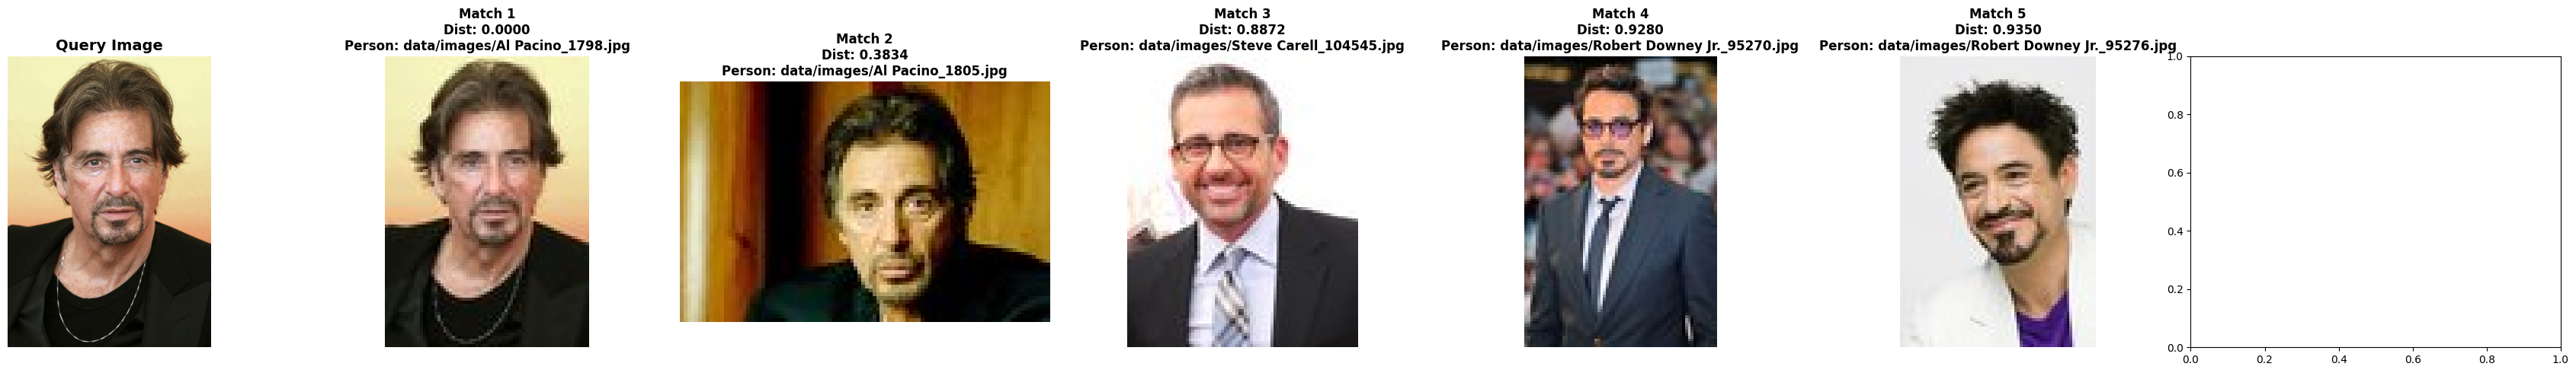

In [10]:
import base64
from io import BytesIO

# Display query + top matches with thumbnails
fig, axes = plt.subplots(1, n_results + 1, figsize=(5 * (n_results + 1), 5))

# Query image
axes[0].imshow(query_img)
axes[0].set_title('Query Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Top matches
for i, (doc, dist, meta) in enumerate(zip(
    results['documents'][0],
    results['distances'][0],
    results['metadatas'][0]
), 1):
    
    print(f"Match {i}:")
    print(f"  Image: {doc}")
    print(f"  Distance: {dist:.4f}")
    print(f"  Person ID: {meta['person_id']}\n")
    
    # Get thumbnail from base64
    thumbnail_b64 = meta.get('thumbnail')
    
    if thumbnail_b64:
        # Decode base64 to image
        img_data = base64.b64decode(thumbnail_b64)
        thumbnail = Image.open(BytesIO(img_data))
        
        axes[i].imshow(thumbnail)
        axes[i].set_title(
            f'Match {i}\nDist: {dist:.4f}\nPerson: {meta["person_id"]}',
            fontsize=12,
            fontweight='bold'
        )
    else:
        axes[i].text(0.5, 0.5, 'No thumbnail', ha='center', va='center')
        axes[i].set_title(f'Match {i} (No thumbnail)', fontsize=12)
    
    axes[i].axis('off')

plt.tight_layout()
plt.show()